# Pretrain EfficientNetB5 on CelebA for Gender Classification on Adience Dataset

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import KFold

import cv2
import random
from PIL import Image
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB5
from tensorflow.keras import optimizers
from tensorflow import keras

import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
print(tf.__version__)

/mnt/local/yuxin/anaconda3/envs/gender/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2022-11-10 23:08:31.959764: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1


In [2]:
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

2022-11-10 23:08:44.161860: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

2022-11-10 23:08:44.162587: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-10 23:08:44.205938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 23:08:44.207057: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-11-10 23:08:44.207231: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 23:08:44.208266: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:

In [3]:
device_lib.list_local_devices()

2022-11-10 23:08:44.278255: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 23:08:44.279150: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-10 23:08:44.449309: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 23:08:44.449619: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13618976783445787980,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9994976640
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12530790860772976218
 physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10258209856
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12640942020756568050
 physical_device_desc: "device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5"]

# Preprocess CelebA Dataset

In [4]:
train_datagen = ImageDataGenerator( # Data Augumentation for test data
                                    rescale=1./255,
                                    rotation_range=30,
                                    shear_range=0.3,
                                    zoom_range=0.3)

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_gen = train_datagen.flow_from_directory('./CelebA_Dataset/Train',
                                            target_size=(227, 227),
                                            batch_size=32,
                                            class_mode='binary')

valid_gen = test_datagen.flow_from_directory('./CelebA_Dataset/Validation',
                                           target_size=(227, 227),
                                           batch_size=32,
                                           class_mode='binary')

test_gen = test_datagen.flow_from_directory('./CelebA_Dataset/Test',
                                           target_size=(227, 227),
                                           batch_size=32,
                                           class_mode='binary')

Found 160000 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.
Found 20001 images belonging to 2 classes.


# Create Model
---
## Hyperparameters

In [6]:
batch_size = 32
epochs = 20
target_size = (227, 227) # (64, 64)
input_shape = (227, 227, 3) #(64, 64, 3)

# random seed
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [20]:
# init your model here before complilation
model = EfficientNetB5(weights='imagenet',
                        include_top=False,
                        input_shape=input_shape)

# input (1, 227, 227, 3) -> output (1, 5, 5, 2048)

Model: "efficientnetb5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 227, 227, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 227, 227, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 229, 229, 3)  0           normalization_1[0][0]            
_____________________________________________________________________________________

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.514339 to fit



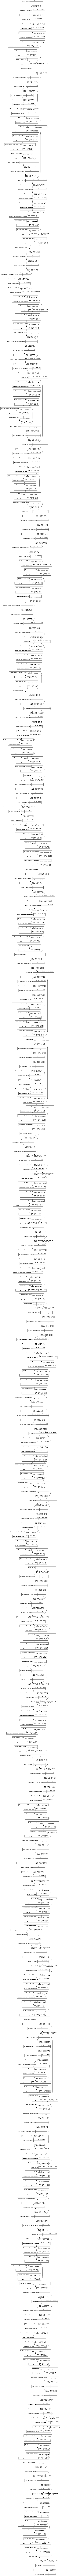

In [21]:
# visualize your model

from tensorflow.keras.utils import plot_model

model.summary()
plot_model(model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)
# plot_model(model)

In [22]:
# Freeze the pre-trained weights initially to train the added layers first
model.trainable = False 

# best hyperparameters
best_hyperparameters= {'hidden_size_1': 512,
                       'dropout': 0.5,
                       'hidden_size_2': 512,
                       'learning_rate': 0.00012206725750339634}

# Adding custom Layers
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)

# 2 -> 1
predictions = Dense(1, activation="sigmoid")(x)

In [23]:
# creating the final model 
our_model = Model(inputs=model.input, outputs=predictions)
our_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 227, 227, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 227, 227, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 229, 229, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

In [31]:
# adapt learning rate -> 1e-5
our_model.compile(optimizer=Adam(learning_rate=1e-6),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [32]:
patience = 5
verbose = 1
factor = 0.50
min_lr = 0.0001

def get_call_backs():
    lrd = ReduceLROnPlateau(monitor = 'val_loss',
                            patience = patience,
                            verbose = verbose ,
                            factor = factor,
                            min_lr = min_lr)

    mcp = ModelCheckpoint('Efficientnet_celebA.h5')

    es = EarlyStopping(verbose=verbose, patience=patience)
    
    return [lrd, mcp, es]

In [33]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# training
history = our_model.fit(
    train_gen, 
    batch_size=batch_size, 
    epochs=epochs, 
    steps_per_epoch=70,
    validation_steps=50,
    validation_data=valid_gen, 
    callbacks=get_call_backs())

Epoch 1/20
70/70 [==============================] - 43s 539ms/step - loss: 0.6928 - accuracy: 0.5486 - val_loss: 0.6732 - val_accuracy: 0.6044
Epoch 2/20
70/70 [==============================] - 33s 475ms/step - loss: 0.6826 - accuracy: 0.5806 - val_loss: 0.6673 - val_accuracy: 0.6250
Epoch 3/20
70/70 [==============================] - 35s 502ms/step - loss: 0.6880 - accuracy: 0.5567 - val_loss: 0.6708 - val_accuracy: 0.6144
Epoch 4/20
70/70 [==============================] - 34s 490ms/step - loss: 0.6793 - accuracy: 0.5857 - val_loss: 0.6756 - val_accuracy: 0.5975
Epoch 5/20
70/70 [==============================] - 34s 483ms/step - loss: 0.6840 - accuracy: 0.5841 - val_loss: 0.6735 - val_accuracy: 0.6050
Epoch 6/20
70/70 [==============================] - 36s 509ms/step - loss: 0.6770 - accuracy: 0.5908 - val_loss: 0.6725 - val_accuracy: 0.6081
Epoch 7/20
70/70 [==============================] - 33s 477ms/step - loss: 0.6843 - accuracy: 0.5821 - val_loss: 0.6784 - val_accuracy: 0.5875

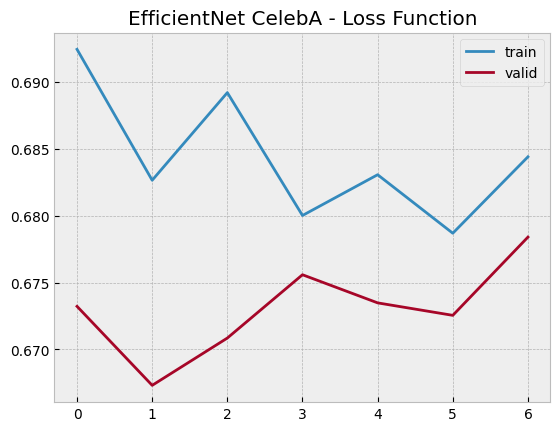

In [34]:
plt.style.use("bmh")

# Plot loss function value through epochs
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')

plt.legend(loc='upper right')
plt.title('EfficientNet CelebA - Loss Function')
plt.show()

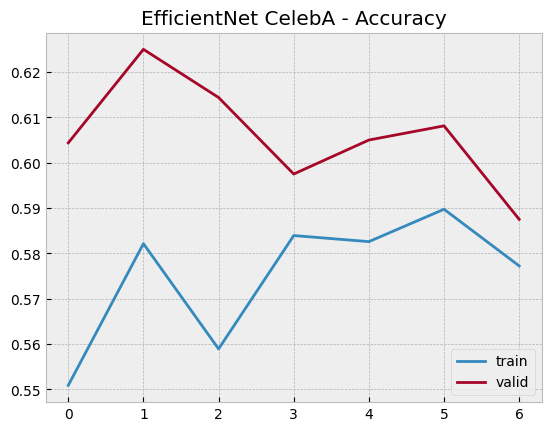

In [35]:
# Plot accuracy through epochs

plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')

plt.legend(loc='lower right')
plt.title('EfficientNet CelebA - Accuracy')
plt.show()

In [ ]:
# test
# test_loss, test_acc = our_model.evaluate(test_gen, verbose=2)
# print(test_acc)

# Preprocess Adience Dataset

In [38]:
# load data
ADIENCE_PATH = './Adience'
print(os.listdir(path=ADIENCE_PATH))

all_folds={}
for i in range(5):
    all_folds[i]=pd.read_csv(os.path.join(ADIENCE_PATH, f'fold_{i}_data.txt'),sep = "\t" )

['AdienceBenchmarkGenderAndAgeClassification', 'faces', 'fold_0_data.txt', 'fold_1_data.txt', 'fold_2_data.txt', 'fold_3_data.txt', 'fold_4_data.txt', '__MACOSX']


In [39]:
total_data = pd.concat([all_folds[i] for i in range(5)],ignore_index=True)
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             19370 non-null  object
 1   original_image      19370 non-null  object
 2   face_id             19370 non-null  int64 
 3   age                 19370 non-null  object
 4   gender              18591 non-null  object
 5   x                   19370 non-null  int64 
 6   y                   19370 non-null  int64 
 7   dx                  19370 non-null  int64 
 8   dy                  19370 non-null  int64 
 9   tilt_ang            19370 non-null  int64 
 10  fiducial_yaw_angle  19370 non-null  int64 
 11  fiducial_score      19370 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.8+ MB


In [40]:
df = total_data[['age', 'gender', 'x', 'y', 'dx', 'dy']].copy()

img_path = []

for row in total_data.iterrows():
    path = f"{ADIENCE_PATH}/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)
df['img_path'] = img_path

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       19370 non-null  object
 1   gender    18591 non-null  object
 2   x         19370 non-null  int64 
 3   y         19370 non-null  int64 
 4   dx        19370 non-null  int64 
 5   dy        19370 non-null  int64 
 6   img_path  19370 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.0+ MB


In [41]:
df = df.dropna()
unbiased_data = df[df.gender != 'u'].copy()
unbiased_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17492 entries, 0 to 19345
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       17492 non-null  object
 1   gender    17492 non-null  object
 2   x         17492 non-null  int64 
 3   y         17492 non-null  int64 
 4   dx        17492 non-null  int64 
 5   dy        17492 non-null  int64 
 6   img_path  17492 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.1+ MB


In [42]:
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}

unbiased_data['gender'] = unbiased_data['gender'].apply(lambda g: gender_to_label_map[g])

unbiased_data.head()

age  gender     x     y    dx    dy  \
0  (25, 32)       0     0   414  1086  1383   
1  (25, 32)       1   301   105   640   641   
2  (25, 32)       0  2395   876   771   771   
3  (25, 32)       1   752  1255   484   485   
4  (25, 32)       1   175    80   769   768   

                                            img_path  
0  ./Adience/faces/30601258@N03/coarse_tilt_align...  
1  ./Adience/faces/30601258@N03/coarse_tilt_align...  
2  ./Adience/faces/30601258@N03/coarse_tilt_align...  
3  ./Adience/faces/30601258@N03/coarse_tilt_align...  
4  ./Adience/faces/30601258@N03/coarse_tilt_align...

# Create Dataset

In [43]:
X = unbiased_data[['img_path']]
y = unbiased_data[['gender']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))

Train data shape (12244, 1)
Test data shape (5248, 1)


In [44]:
train_images = []
test_images = []

for row in X_train.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))   # Resize the image
    data = np.asarray(image)
    train_images.append(data)

for row in X_test.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)

train_images = np.asarray(train_images)
test_images = np.asarray(test_images)

print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))

Train images shape (12244, 227, 227, 3)
Test images shape (5248, 227, 227, 3)


# Transfer Learning

In [49]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

def get_call_backs():
    lrd = ReduceLROnPlateau(monitor = 'val_loss',
                            patience = patience,
                            verbose = verbose ,
                            factor = factor,
                            min_lr = min_lr)
    
    mcp = ModelCheckpoint('pretrain_efficientnet.h5')

    es = EarlyStopping(verbose=verbose, patience=3)
    
    return [lrd, mcp, es]

best_lr = 0.00012206725750339634
our_model.compile(optimizer=Adam(best_lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# training
history = our_model.fit(
    train_images, y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=(test_images, y_test), 
    callbacks=get_call_backs())

2022-11-10 23:37:02.800525: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1892763228 exceeds 10% of free system memory.


Epoch 1/20
382/383 [============================>.] - ETA: 0s - loss: 0.4679 - accuracy: 0.7769

2022-11-10 23:37:46.064916: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:37:46.181896: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:37:46.301537: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:37:46.418597: W tensorflow/stream_executor/gpu/

2022-11-10 23:37:49.386386: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:37:49.503841: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:37:49.622170: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:37:49.739314: W tensorflow/stream_executor/gpu/

2022-11-10 23:37:52.761961: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:37:52.879524: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:37:52.997302: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:37:53.115429: W tensorflow/stream_executor/gpu/

2022-11-10 23:37:56.090753: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:37:56.208345: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:37:56.327200: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:37:56.446786: W tensorflow/stream_executor/gpu/

2022-11-10 23:37:59.398316: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:37:59.516536: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:37:59.639735: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:37:59.760046: W tensorflow/stream_executor/gpu/

2022-11-10 23:38:02.718031: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:02.837893: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:02.955703: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:03.074591: W tensorflow/stream_executor/gpu/

2022-11-10 23:38:06.310364: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:06.429550: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:06.547937: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:06.666013: W tensorflow/stream_executor/gpu/

2022-11-10 23:38:09.633267: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:09.752565: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:09.871521: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:09.995570: W tensorflow/stream_executor/gpu/

2022-11-10 23:38:12.964976: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:13.083177: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:13.200952: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:13.319615: W tensorflow/stream_executor/gpu/

2022-11-10 23:38:16.287966: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:16.407005: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:16.524961: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:16.644102: W tensorflow/stream_executor/gpu/

2022-11-10 23:38:19.606728: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:19.724341: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:19.842014: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:19.959982: W tensorflow/stream_executor/gpu/

2022-11-10 23:38:22.933849: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:23.051612: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:23.169505: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:23.289451: W tensorflow/stream_executor/gpu/

2022-11-10 23:38:26.253232: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:26.371384: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:26.491611: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:26.610298: W tensorflow/stream_executor/gpu/

2022-11-10 23:38:29.590501: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:29.721542: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:29.839963: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:29.961998: W tensorflow/stream_executor/gpu/

2022-11-10 23:38:32.939114: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:33.058493: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:33.176553: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-11-10 23:38:33.308555: W tensorflow/stream_executor/gpu/

383/383 [==============================] - ETA: 0s - loss: 0.4677 - accuracy: 0.7770

2022-11-10 23:38:34.865053: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'



383/383 [==============================] - 108s 268ms/step - loss: 0.4675 - accuracy: 0.7772 - val_loss: 0.3270 - val_accuracy: 0.8584
Epoch 2/20
383/383 [==============================] - 53s 137ms/step - loss: 0.3094 - accuracy: 0.8646 - val_loss: 0.2876 - val_accuracy: 0.8780
Epoch 3/20
383/383 [==============================] - 54s 140ms/step - loss: 0.2806 - accuracy: 0.8800 - val_loss: 0.2873 - val_accuracy: 0.8758
Epoch 4/20
383/383 [==============================] - 54s 140ms/step - loss: 0.2546 - accuracy: 0.8960 - val_loss: 0.2641 - val_accuracy: 0.8937
Epoch 5/20
383/383 [==============================] - 54s 141ms/step - loss: 0.2212 - accuracy: 0.9098 - val_loss: 0.2516 - val_accuracy: 0.8973
Epoch 6/20
383/383 [==============================] - 54s 141ms/step - loss: 0.2019 - accuracy: 0.9195 - val_loss: 0.2527 - val_accuracy: 0.8986
Epoch 7/20
383/383 [==============================] - 54s 141ms/step - loss: 0.1939 - accuracy: 0.9244 - val_loss: 0.2479 - val_accuracy: 0.

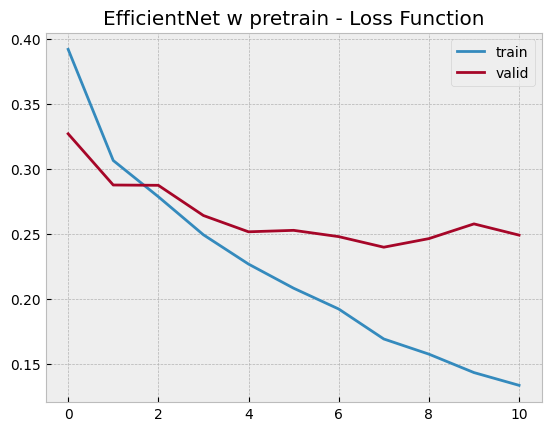

In [50]:
plt.style.use("bmh")

# Plot loss function value through epochs
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')

plt.legend(loc='upper right')
plt.title('EfficientNet w pretrain - Loss Function')
plt.show()

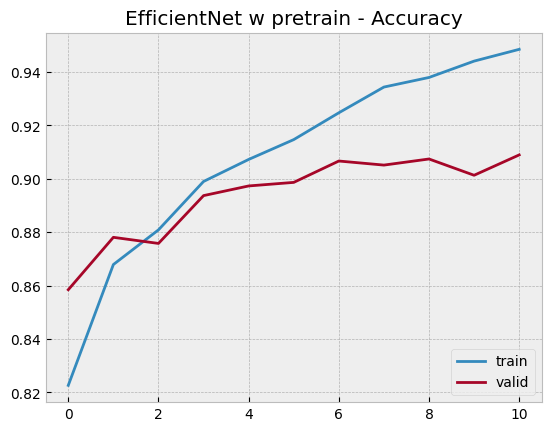

In [51]:
# Plot accuracy through epochs

plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')

plt.legend(loc='lower right')
plt.title('EfficientNet w pretrain - Accuracy')
plt.show()

In [52]:
# test
test_loss, test_acc = our_model.evaluate(test_images, y_test, verbose=2)
print(test_acc)

164/164 - 15s - loss: 0.2490 - accuracy: 0.9089
0.9089176654815674
